In [1]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(X): return 1/(1 + np.exp(-X))
def dsigmoid(X): return sigmoid(X)*(1 - sigmoid(X))

def tanh(X): return np.tanh(X)
def dtanh(X): return 1 + tanh(X)**2

def log_probability(Y, B): return -(Y*np.log(B) + (1 - Y)*np.log(1 - B))
def dlog_probability(Y, B): return -(Y/B - (1 - Y)/(1 - B))


def set_normalize(X):
    means = np.mean(X, axis=1, keepdims=True)
    stds = np.std(X, axis=1, keepdims=True)
    def normalize(X):
        return (X - means)/stds
    return normalize


def print_matricies(A, decimals):
    print(np.round(A[0], decimals))
    for a in range(1, len(A)):
        print()
        print(np.round(A[a], decimals))

In [2]:
# MODEL FUNCTIONS

#  M -- array of layer sizes, [M0, M1, M2, ...]
#  m0, m1, m2, ... --- size iterators
#  L -- number of layers
#  l -- index used to iterate though layers
#  W -- list of weight matricies, [W10, W21, W32, ...]
#  b -- list of offset vectors, [b1, b2, b3, ...]
#  g -- list of non-linear functions
# dg -- list of non-linear function derivatives
#  X -- input data
#  Y -- output data
#  A -- matrix of activation units, [A0, A1, A2, ...]
#  Z -- matrix of linear units, [Z1, Z2, Z3, ...]
#  B -- last activation unit matrix, A[-1]
# dB -- dA[-1]
#  F -- function for calculating cost
# dF -- derivative for calculting cost gradient
# dA -- [dA0, dA1, dA2, ...]
# dZ -- [dZ1, dZ2, dZ3, ...]
# dW -- [dW10, dW21, dW32, ...]
# db -- [db1, db2, db3, ...]
# T  -- number of training cases
# t  -- training iterator
# alpha -- learning rate
# epsilon -- used for gradient checking
# DW, Db -- numdric gradient calculations


def initialize_weights(M):
    L = len(M) - 1
    W = [0]*L
    b = [0]*L
    for l in range(L):
        W[l] = np.random.randn(M[l + 1], M[l])*0.01
        b[l] = np.zeros([M[l + 1], 1])
    return W, b


def propagate_forward(X, W, b, g):
    L = len(W)
    A = [X] + [0]*L
    Z = [0]*L
    for l in range(L):
        Z[l] = np.dot(W[l], A[l]) + b[l]
        A[l + 1] = g[l](Z[l])
    return A, Z


def calculate_cost(Y, B, F):
    MY, N = Y.shape
    J = np.sum(F(Y, B))/N
    return J


def calculate_cost_gradient(Y, B, dF):
    MY, N = Y.shape
    dB = dF(Y, B).T/N
    return dB


def propagate_backwards(dB, W, b, dg, Z):
    L = len(W)
    dA = [0]*L + [dB]
    dZ = [0]*L
    for l in reversed(range(L)):
        dZ[l] = dA[l + 1]*dg[l](Z[l].T)
        dA[l] = np.dot(dZ[l], W[l])
    return dA, dZ


def calculate_weight_gradients(A, dZ):
    L = len(A) - 1
    dW = [0]*L
    db = [0]*L
    for l in range(L):
        dW[l] = np.dot(A[l], dZ[l])
        db[l] = np.sum(dZ[l], axis=0, keepdims=True)
    return dW, db


def calculate_weight_gradients_numerically(X, Y, W, b, g, F, epsilon):
    L = len(W)
    DW = [0]*L
    Db = [0]*L
    for l in range(L):
        M, N = np.shape(W[l])
        DW[l] = np.zeros([N, M])
        Db[l] = np.zeros([1, M])
        for m in range(M):
            for n in range(N):
                temp = W[l][m, n]
                W[l][m, n] = temp - epsilon; AL, ZL = propagate_forward(X, W, b, g)
                W[l][m, n] = temp + epsilon; AR, ZR = propagate_forward(X, W, b, g)
                W[l][m, n] = temp
                JL = calculate_cost(Y, AL[-1], F)
                JR = calculate_cost(Y, AR[-1], F)
                DW[l][n, m] = (JR - JL)/2/epsilon
            temp = b[l][m, 0]
            b[l][m, 0] = temp - epsilon; AL, ZL = propagate_forward(X, W, b, g)
            b[l][m, 0] = temp + epsilon; AR, ZR = propagate_forward(X, W, b, g)
            b[l][m, 0] = temp
            JL = calculate_cost(Y, AL[-1], F)
            JR = calculate_cost(Y, AR[-1], F)
            Db[l][0, m] = (JR - JL)/2/epsilon
    return DW, Db


def calculate_weight_gradients_error(dW, db, DW, Db):
    L = len(dW)
    dW_error = [0]*L
    db_error = [0]*L
    for l in range(L):
        dW_error[l] = np.linalg.norm(dW[l] - DW[l])/(np.linalg.norm(dW[l]) + np.linalg.norm(DW[l]))
        db_error[l] = np.linalg.norm(db[l] - Db[l])/(np.linalg.norm(db[l]) + np.linalg.norm(Db[l]))
    return dW_error, db_error


def print_weight_gradients_error(X, Y, W, b, g, dg, F, dF, epsilon):
    A, Z = propagate_forward(X, W, b, g)
    dB = calculate_cost_gradient(Y, A[-1], dF)
    dA, dZ = propagate_backwards(dB, W, b, dg, Z)
    dW, db = calculate_weight_gradients(A, dZ)
    DW, Db = calculate_weight_gradients_numerically(X, Y, W, b, g, F, epsilon)
    dW_error, db_error = calculate_weight_gradients_error(dW, db, DW, Db)    
    L = len(W)
    for l in range(L):
        print("max dW[{}] error = {:<.2e}".format(l, np.max(dW_error[l])))
        print("max db[{}] error = {:<.2e}".format(l, np.max(db_error[l])))


def update_weights(W, b, dW, db, alpha):
    L = len(W)
    for l in range(L):
        W[l] = W[l] - alpha*dW[l].T
        b[l] = b[l] - alpha*db[l].T
    return W, b


def print_cost(t, J, step):
    if step != 0:
        if t == 0:
            print("{:<10}{}".format("t =", "J ="))
            print("{:<10}{:<.6f}".format(t, J))            
        elif t%step == 0:
            print("{:<10}{:<.6f}".format(t, J))

    
def learn_weights(X, Y, W, b, g, dg, F, dF, alpha, T, step):
    J_list = []   
    A, Z = propagate_forward(X, W, b, g)
    B = A[-1]
    J = calculate_cost(Y, B, F)
    J_list += [J]
    print_cost(0, J, step)
    for t in range(1, T + 1):
        dB = calculate_cost_gradient(Y, B, dF)
        dA, dZ = propagate_backwards(dB, W, b, dg, Z)
        dW, db = calculate_weight_gradients(A, dZ)
        W, b = update_weights(W, b, dW, db, alpha)
        A, Z = propagate_forward(X, W, b, g)
        B = A[-1]
        J = calculate_cost(Y, B, F)
        J_list += [J]
        print_cost(t, J, step)
    return W, b, J_list

In [3]:
# DATA
X = np.array([[0, 1, 0, 0, 1, 1, 0, 1],
              [0, 0, 1, 0, 1, 0, 1, 1],
              [0, 0, 0, 1, 0, 1, 1, 1]])

Y = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
              [0, 1, 1, 1, 0, 0, 0, 1]])


# HYPERPARAMETERS
m = np.array([3, 3, 2])
g = [sigmoid, sigmoid]
dg = [dsigmoid, dsigmoid]
F = log_probability
dF = dlog_probability


# CHECK GRADIENTS
epsilon = 1e-7

W, b = initialize_weights(m)
print_weight_gradients_error(X, Y, W, b, g, dg, F, dF, epsilon)

max dW[0] error = 7.82e-07
max db[0] error = 1.55e-05
max dW[1] error = 2.22e-07
max db[1] error = 1.45e-07


In [4]:
# DATA
X = np.array([[0, 1, 0, 0, 1, 1, 0, 1],
              [0, 0, 1, 0, 1, 0, 1, 1],
              [0, 0, 0, 1, 0, 1, 1, 1]])

Y = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
              [0, 1, 1, 1, 0, 0, 0, 1]])


# HYPERPARAMETERS
M = np.array([3, 3, 2])

g = [sigmoid, sigmoid]
dg = [dsigmoid, dsigmoid]

F = log_probability
dF = dlog_probability

alpha = 1
T = 10000
step = T/10


# MAIN
W, b = initialize_weights(m)
W, b, J_list = learn_weights(X, Y, W, b, g, dg, F, dF, alpha, T, step)
A, Z = propagate_forward(X, W, b, g)

print("\nA =")
print_matricies(A, 3)

print("\nW =")
print_matricies(W, 3)

print("\nb =")
print_matricies(b, 3)

t =       J =
0         1.386324
1000      0.096615
2000      0.022899
3000      0.012604
4000      0.008642
5000      0.006558
6000      0.005277
7000      0.004412
8000      0.003788
9000      0.003317
10000     0.002950

A =
[[0 1 0 0 1 1 0 1]
 [0 0 1 0 1 0 1 1]
 [0 0 0 1 0 1 1 1]]

[[ 0.033  0.977  0.977  0.977  1.     1.     1.     1.   ]
 [ 0.     0.     0.     0.     0.054  0.054  0.054  0.884]
 [ 1.     0.98   0.98   0.98   0.014  0.014  0.014  0.   ]]

[[ 0.     0.001  0.001  0.001  0.999  0.999  0.999  1.   ]
 [ 0.004  0.998  0.998  0.998  0.002  0.002  0.002  0.998]]

W =
[[ 7.109  7.109  7.109]
 [ 4.89   4.89   4.89 ]
 [-8.145 -8.145 -8.145]]

[[  6.735   4.399 -14.755]
 [ 12.555  14.957  13.852]]

b =
[[ -3.376]
 [-12.639]
 [ 12.026]]

[[  0.453]
 [-19.678]]


In [5]:
# Hand crafted weights inspired by the net output
# the first layer counts
# the second layer converts to binary

X = np.array([[0, 1, 0, 0, 1, 1, 0, 1],
              [0, 0, 1, 0, 1, 0, 1, 1],
              [0, 0, 0, 1, 0, 1, 1, 1]])

Y = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
              [0, 1, 1, 1, 0, 0, 0, 1]])

W10 = np.array([[20, 20, 20],
                [20, 20, 20],
                [20, 20, 20]])

b1 = np.array([[-10], [-30], [-50]])

W21 = np.array([[ 0,  20, 20],
                [20, -20, 20]])

b2 = np.array([[-10], [-10]])

W = [W10, W21]
b = [b1, b2]
A, Z = propagate_forward(X, W, b, g)

print("\nA =")
print_matricies(A, 3)


A =
[[0 1 0 0 1 1 0 1]
 [0 0 1 0 1 0 1 1]
 [0 0 0 1 0 1 1 1]]

[[ 0.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]

[[ 0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  0.  0.  0.  1.]]


In [6]:
# HYPERPARAMETERS
m = np.array([2, 4])

g = [sigmoid, sigmoid]
dg = [dsigmoid, dsigmoid]

F = log_probability
dF = dlog_probability

alpha = 5
T = 10000
step = T/10


# DATA
X = np.array([[0, 0, 1, 1],
              [0, 1, 0, 1]])

Y = np.array([[0, 0, 0, 1],
              [0, 0, 1, 0],
              [0, 1, 0, 0],
              [1, 0, 0, 0]])


# MAIN
W, b = initialize_weights(m)
W, b, J_list = learn_weights(X, Y, W, b, g, dg, F, dF, alpha, T, step)
A, Z = propagate_forward(X, W, b, g)

print("\nA =")
print_matricies(A, 3)

print("\nW =")
print_matricies(W, 3)

print("\nb =")
print_matricies(b, 3)

print("\nZ =")
print_matricies(Z, 3)

t =       J =
0         2.776363
1000      0.008871
2000      0.004422
3000      0.002944
4000      0.002207
5000      0.001765
6000      0.001470
7000      0.001260
8000      0.001102
9000      0.000979
10000     0.000881

A =
[[0 0 1 1]
 [0 1 0 1]]

[[ 0.     0.     0.     0.999]
 [ 0.     0.     1.     0.   ]
 [ 0.     1.     0.     0.   ]
 [ 1.     0.     0.     0.   ]]

W =
[[ 15.307  15.307]
 [ 16.38  -16.785]
 [-16.785  16.38 ]
 [-16.561 -16.561]]

b =
[[-23.129]
 [ -8.334]
 [ -8.334]
 [  7.822]]

Z =
[[-23.129  -7.822  -7.822   7.485]
 [ -8.334 -25.119   8.046  -8.739]
 [ -8.334   8.046 -25.119  -8.739]
 [  7.822  -8.739  -8.739 -25.3  ]]


In [7]:
X = np.array([[0, 0, 1, 1],
              [0, 1, 0, 1]])

Y = np.array([[0, 0, 0, 1],
              [0, 0, 1, 0],
              [0, 1, 0, 0],
              [1, 0, 0, 0]])

W10 = np.array([[ 20,  20],
                [ 20, -20],
                [-20,  20],
                [-20, -20]])

b1 = np.array([[-30, -10, -10, 10]])

W = [W10]
b = [b1]

A, Z = propagate_forward(X, W, b, g)

print("\nA =")
print_matricies(A, 3)

print("\nZ =")
print_matricies(Z, 3)


A =
[[0 0 1 1]
 [0 1 0 1]]

[[ 0.  1.  1.  1.]
 [ 0.  0.  1.  1.]
 [ 0.  1.  0.  1.]
 [ 0.  0.  0.  0.]]

Z =
[[-30  10  10  50]
 [-30 -30  10  10]
 [-30  10 -30  10]
 [-30 -30 -30 -30]]


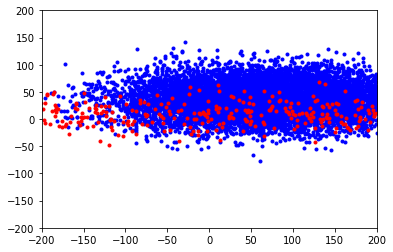

In [8]:
M = 4
N = 10000

X = np.random.randn(M, N)
X *= 100*np.random.rand(M, 1)
X += 100*np.random.rand(M, 1)

normalize = set_normalize(X)

X = np.random.randn(M, N)
X *= 100*np.random.rand(M, 1)
X += 100*np.random.rand(M, 1)

Y = normalize(X)

plt.plot(X[0, :], X[1, :],  'b.')
plt.plot(50*Y[0, :], 50*Y[1, :],  'r.')
plt.axis([-200, 200, -200, 200])
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(X): return 1/(1 + np.exp(-X))
def dsigmoid(X): return sigmoid(X)*(1 - sigmoid(X))

def tanh(X): return np.tanh(X)
def dtanh(X): return 1 + tanh(X)**2

def log_probability(Y, B): return -(Y*np.log(B) + (1 - Y)*np.log(1 - B))
def dlog_probability(Y, B): return -(Y/B - (1 - Y)/(1 - B))


def set_normalize(X):
    means = np.mean(X, axis=1, keepdims=True)
    stds = np.std(X, axis=1, keepdims=True)
    def normalize(X):
        return (X - means)/stds
    return normalize


def print_matricies(A, decimals):
    print(np.round(A[0], decimals))
    for a in range(1, len(A)):
        print()
        print(np.round(A[a], decimals))

In [10]:
def initialize_weights(model):
    [M, g, dg, F, dF] = model
    L = len(M) - 1
    W = [0]*L
    b = [0]*L
    for l in range(L):
        W[l] = np.random.randn(M[l + 1], M[l])*0.01
        b[l] = np.zeros([M[l + 1], 1])
    return [W, b]


def propagate_forward(data, weights, model):
    [X, Y] = data
    [W, b] = weights
    [M, g, dg, F, dF] = model
    L = len(M) - 1
    A = [X] + [0]*L
    Z = [0]*L
    for l in range(L):
        Z[l] = np.dot(W[l], A[l]) + b[l]
        A[l + 1] = g[l](Z[l])
    return [A, Z]


def calculate_cost(data, weights, model):
    [X, Y] = data
    [W, b] = weights
    [M, g, dg, F, dF] = model
    cache = propagate_forward(data, weights, model)
    [A, Z] = cache
    MY, N = Y.shape
    J = np.sum(F(Y, A[-1]))/N
    return [J, cache]


def calculate_cost_gradient(data, model, cache):
    [X, Y] = data
    [M, g, dg, F, dF] = model
    [A, Z] = cache
    MY, N = Y.shape
    dB = dF(Y, A[-1]).T/N
    return dB


def propagate_backwards(data, weights, model, cache):
    [X, Y] = data
    [W, b] = weights
    [M, g, dg, F, dF] = model
    [A, Z] = cache
    L = len(W)
    dA = [0]*L + [calculate_cost_gradient(data, model, cache)]
    dZ = [0]*L
    for l in reversed(range(L)):
        dZ[l] = dA[l + 1]*dg[l](Z[l].T)
        dA[l] = np.dot(dZ[l], W[l])
    return [dA, dZ]


def calculate_weight_gradients(data, weights, model, cache):
    [X, Y] = data
    [W, b] = weights
    [M, g, dg, F, dF] = model
    [A, Z] = cache
    [dA, dZ] = propagate_backwards(data, weights, model, cache)
    L = len(A) - 1
    dW = [0]*L
    db = [0]*L
    for l in range(L):
        dW[l] = np.dot(A[l], dZ[l])
        db[l] = np.sum(dZ[l], axis=0, keepdims=True)
    return [dW, db]




M = np.array([3, 3, 2])
g = [sigmoid, sigmoid]
dg = [dsigmoid, dsigmoid]
F = log_probability
dF = dlog_probability

model = [M, g, dg, F, dF]

X = np.array([[0, 1, 0, 0, 1, 1, 0, 1],
              [0, 0, 1, 0, 1, 0, 1, 1],
              [0, 0, 0, 1, 0, 1, 1, 1]])

Y = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
              [0, 1, 1, 1, 0, 0, 0, 1]])

data = [X, Y]


weights = initialize_weights(model)

[J, cache] = calculate_cost(data, weights, model)

weight_grads = calculate_weight_gradients(data, weights, model, cache)



In [11]:
weight_grads

[[array([[ 0.00035081,  0.00010533, -0.0002949 ],
         [ 0.00035085,  0.00010534, -0.0002949 ],
         [ 0.0003508 ,  0.00010533, -0.00029491]]),
  array([[-0.000511  ,  0.00085067],
         [-0.00052185,  0.00085068],
         [ 0.00075485,  0.00084206]])],
 [array([[  7.89783286e-06,   3.02059627e-07,  -1.54149607e-06]]),
  array([[-0.00064444,  0.00169875]])]]